Imports

In [21]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
import time

In [15]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Initial Preprocessing

In [16]:
from pandas import read_csv
data = read_csv('UCI_2010_2014.csv')
data = data.drop('No', axis=1, inplace=False)

In [17]:
data = data.drop(['year','month','day','hour'], axis=1, inplace=False)

In [18]:
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']

In [19]:
# mark all NA values with 0
data['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
data = data[24:]
# summarize first 5 rows
print(data.head(5))
# save to file
#data.to_csv('pollution.csv')

    pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
24      129.0  -16  -4.0  1020.0      SE     1.79     0     0
25      148.0  -15  -4.0  1020.0      SE     2.68     0     0
26      159.0  -11  -5.0  1021.0      SE     3.57     0     0
27      181.0   -7  -5.0  1022.0      SE     5.36     1     0
28      138.0   -7  -5.0  1022.0      SE     6.25     2     0


## Baseline LSTM + room to change network architecture

In [22]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features (after I reframe into a supervised learning problem)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled = scaler.fit_transform(values)
# frame as supervised learning -
####### Can change t_input timesteps here ##########  ### I changed it to time lag = 4
reframed = series_to_supervised(values, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)
print(reframed.head())

# split into train and test sets
values = reframed.values
#values = scaled
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(values[:,:-1])
scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
values = np.column_stack((scaled_features, scaled_label))

n_train_hours = 365 * 24 + (365 * 48)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
#print('hiii')
#print(scaled)
# design network
model = Sequential()
model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
start = time.time()

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      129.0      -16.0       -4.0     1020.0        2.0       1.79   
2      148.0      -15.0       -4.0     1020.0        2.0       2.68   
3      159.0      -11.0       -5.0     1021.0        2.0       3.57   
4      181.0       -7.0       -5.0     1022.0        2.0       5.36   
5      138.0       -7.0       -5.0     1022.0        2.0       6.25   

   var7(t-1)  var8(t-1)  var1(t)  
1        0.0        0.0    148.0  
2        0.0        0.0    159.0  
3        0.0        0.0    181.0  
4        1.0        0.0    138.0  
5        2.0        0.0    109.0  
(26280, 1, 8) (26280,) (17519, 1, 8) (17519,)


Train on 26280 samples, validate on 17519 samples
Epoch 1/2
26280/26280 [==============================] - 3s 113us/step - loss: 0.0280 - val_loss: 0.0144
Epoch 2/2
26280/26280 [==============================] - 2s 85us/step - loss: 0.0149 - val_loss: 0.0137


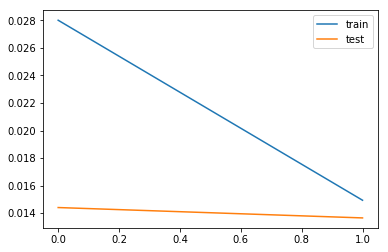

This took 15.304089069366455 seconds.
Test RMSE: 26.921


In [23]:
###################### Can change Epochs, Batch size here #######################
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
end = time.time()
print('This took {} seconds.'.format(end - start))
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)